# 河港課データから川の水位と雨量の関係を解析

日付のくさっているやつがいる。04/01 12:00とか書いてある。どうしよう。フォーマットを指定すれば読めるが、年をファイル名から推定する必要があるし、2種類の書式を判別する必要がある。

前処理をしたほうがましか。

問題を理解した。雨量の値は1時間あたりに換算されていない。15分間隔ではかった降水量は、1時間単位で測った降水量の1/4しかない。それらを混ぜてはいけない。あああ。

In [2]:
try:
    # On Google Colab
    from google.colab import drive

    drive.mount("/content/drive")

    BASEDIR = (
        "drive/MyDrive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/"
    )
except:
    BASEDIR = "./"

In [13]:
import level

from level import scan_data, delayed_data

In [4]:
from IPython.display import display
import seaborn as sns
import datetime


def merge_rain_and_level(雨量, 水位):
    # 最初のデータは同時刻?
    start = np.min([雨量.datetime.iloc[0], 水位.datetime.iloc[0]])
    last = np.max([雨量.datetime.iloc[-1], 水位.datetime.iloc[-1]])

    # なぜか9時間ずれる。
    ticks = pd.DataFrame()
    ticks["unixtime"] = np.arange(start.timestamp(), last.timestamp() + 3600, 3600)
    ticks["datetime"] = pd.to_datetime((ticks.unixtime + 9 * 3600) * 10**9)
    ticks.datetime = ticks.datetime.dt.tz_localize("Asia/Tokyo")
    ticks = pd.merge(ticks, 雨量, on="datetime", how="left")
    ticks = pd.merge(ticks, 水位, on="datetime", how="left")
    return ticks

In [5]:
import numpy as np
from sklearn import linear_model


def regression(雨量, 水位, lookback=30, ax=None, rolling_window=None):
    X = delayed_data(雨量, lookback)
    # 最初が最新になるように反転(インパルス応答の目盛りにあわせる)
    X = X[:, ::-1]
    y = 水位

    Xy = np.concatenate([X, y.to_numpy().reshape(-1, 1)], axis=1)
    Xy = Xy[水位 > 50]  # 異常値を削る。(大月)
    Xy = Xy[~np.isnan(Xy).any(axis=1)]

    reg_model = linear_model.LinearRegression()

    X, y = Xy[:, :-1], Xy[:, -1]

    if rolling_window is not None:
        # y = 水位 - 水位.rolling(rolling_window).mean() # 移動平均
        y -= pd.Series(y).rolling(rolling_window).min()  # 最小値
        Label = "最小値"
        X = X[~np.isnan(y)]
        y = y[~np.isnan(y)]

    reg_model.fit(X, y)
    coefs = np.append(reg_model.coef_, reg_model.intercept_)

    if ax:
        ax.plot(y, label="瞬間値")
        ax.plot(y - X @ coefs[:-1] + 200, label="定常値")
        if rolling_window is not None:
            ax.plot(水位, label="観測値")
            ax.plot(
                水位.rolling(rolling_window).min(),
                label=f"{rolling_window}時間の移動{Label}",
            )

    return coefs

In [16]:
昭和橋水位 = level.scan_data("昭和橋水位", BASEDIR)
昭和橋雨量 = level.scan_data("昭和橋雨量", BASEDIR)

/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling b

04/01 00:00
07/01 00:00
07/01 00:00
03/01 00:00
01/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling b

02/01 00:00
08/01 00:00
11/01 00:00
09/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:


06/01 00:00
05/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling b

05/01 00:00
06/01 00:00
12/01 00:00
08/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling b

11/01 00:00
10/01 00:00
09/01 00:00
07/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:


04/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling b

04/01 00:00
07/01 00:00
03/01 00:00
01/01 00:00
02/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:


08/01 00:00
11/01 00:00
09/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:


06/01 00:00
05/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling b

05/01 00:00
06/01 00:00
12/01 00:00
08/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling b

11/01 00:00
10/01 00:00
09/01 00:00
07/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  try:


04/01 00:00


同じ時刻に異なるデータが記録されている場合は、どちらも信用しない。

In [17]:
np.sum(昭和橋雨量.datetime.duplicated()), np.sum(昭和橋水位.datetime.duplicated())

(np.int64(0), np.int64(0))

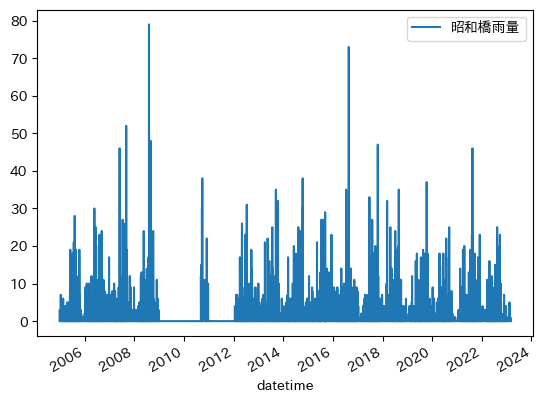

<Axes: xlabel='datetime'>

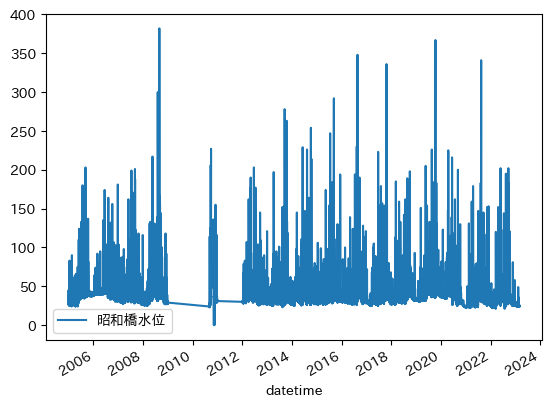

In [19]:
import matplotlib.pyplot as plt

昭和橋雨量2 = 昭和橋雨量.drop_duplicates(["datetime"], keep=False)
昭和橋水位2 = 昭和橋水位.drop_duplicates(["datetime"], keep=False)
昭和橋雨量2.plot("datetime", "昭和橋雨量")
plt.show()
昭和橋水位2.plot("datetime", "昭和橋水位")

なぜか雨量だけ、重複除去でグラフが全く変化してしまう。→雨量は時間で規格化されていない。盲点。

時刻目盛をつけなおす。

,unixtime,datetime,昭和橋雨量,昭和橋水位
0,1.104505e+09,2005-01-01 00:00:00+09:00,0.0,34.0
1,1.104509e+09,2005-01-01 01:00:00+09:00,0.0,33.0
2,1.104512e+09,2005-01-01 02:00:00+09:00,0.0,34.0
3,1.104516e+09,2005-01-01 03:00:00+09:00,0.0,33.0
4,1.104520e+09,2005-01-01 04:00:00+09:00,0.0,32.0


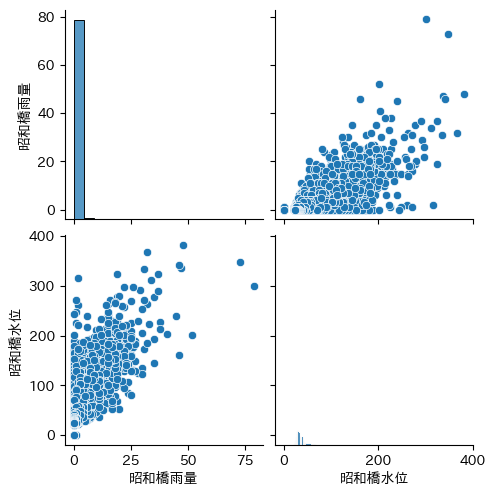

In [20]:
ticks = merge_rain_and_level(昭和橋雨量, 昭和橋水位)
sns.pairplot(ticks[["昭和橋雨量", "昭和橋水位"]])
np.corrcoef(ticks.昭和橋水位, ticks.昭和橋雨量)
ticks.head()

(np.float64(18414.0), np.float64(18504.0))

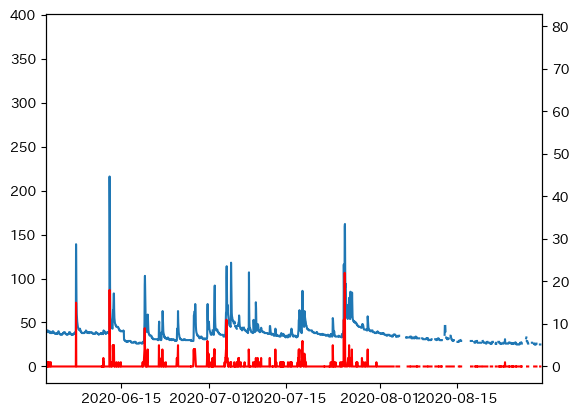

In [21]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ticks.datetime, ticks.昭和橋水位)
ax2.plot(ticks.datetime, ticks.昭和橋雨量, "r")
plt.xlim(datetime.date(2020, 6, 1), datetime.date(2020, 8, 30))

遅延データを作り、インパルス応答を算出する。

完全に連続なデータが得られているなら、高速畳み込み関数が使えるかもしれないが、欠測が多いので、従来通り、Xとyを作って係数を回帰で求める。

In [6]:
大月水位 = level.scan_data("大月水位", BASEDIR)
大月雨量 = level.scan_data("大月雨量", BASEDIR)

/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water

04/01 00:00
07/01 00:00
03/01 00:00
01/01 00:00
02/01 00:00
08/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water

11/01 00:00
09/01 00:00
06/01 00:00
05/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water

05/01 00:00
06/01 00:00
12/01 00:00
08/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water

11/01 00:00
10/01 00:00
09/01 00:00
07/01 00:00
04/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water

04/01 00:00
07/01 00:00
03/01 00:00
01/01 00:00
02/01 00:00
08/01 00:00
11/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


09/01 00:00
06/01 00:00
05/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water

05/01 00:00
06/01 00:00
12/01 00:00
08/01 00:00
11/01 00:00


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:44: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water

10/01 00:00
09/01 00:00
07/01 00:00
04/01 00:00


In [7]:
大月水位

,datetime,大月水位
0,2005-01-01 00:00:00+09:00,172.0
1,2005-01-01 01:00:00+09:00,171.0
2,2005-01-01 02:00:00+09:00,171.0
3,2005-01-01 03:00:00+09:00,170.0
4,2005-01-01 04:00:00+09:00,170.0
...,...,...
667,2023-02-28 19:00:00+09:00,151.0
668,2023-02-28 20:00:00+09:00,151.0
669,2023-02-28 21:00:00+09:00,155.0
670,2023-02-28 22:00:00+09:00,154.0


流量は水位の二乗に比例すると考えると

In [9]:
import pandas as pd

大月流量 = pd.DataFrame()
大月流量["datetime"] = 大月水位.datetime
大月流量["大月流量"] = 大月水位.大月水位**2
大月流量

,datetime,大月流量
0,2005-01-01 00:00:00+09:00,29584.0
1,2005-01-01 01:00:00+09:00,29241.0
2,2005-01-01 02:00:00+09:00,29241.0
3,2005-01-01 03:00:00+09:00,28900.0
4,2005-01-01 04:00:00+09:00,28900.0
...,...,...
667,2023-02-28 19:00:00+09:00,22801.0
668,2023-02-28 20:00:00+09:00,22801.0
669,2023-02-28 21:00:00+09:00,24025.0
670,2023-02-28 22:00:00+09:00,23716.0


/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:73: RuntimeWarning: invalid value encountered in divide
  X_ = np.zeros([L, lookback]) / 0


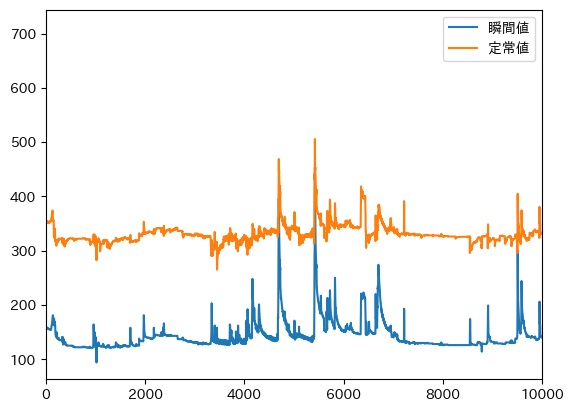

Text(0.5, 1.0, '大月')

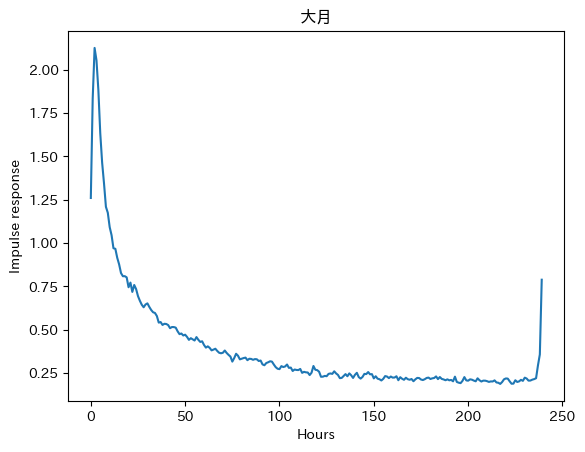

In [14]:
ticks = merge_rain_and_level(大月雨量, 大月水位)
coef = regression(ticks.大月雨量, ticks.大月水位, lookback=24 * 10, ax=plt)
plt.xlim(0, 10000)
plt.legend()
plt.show()
plt.plot(coef[:-1])
plt.xlabel("Hours")
plt.ylabel("Impulse response")
plt.title("大月")
# plt.yscale("log")

なんかてきとうな関数で近似できないものか。

Text(0.5, 1.0, '大月')

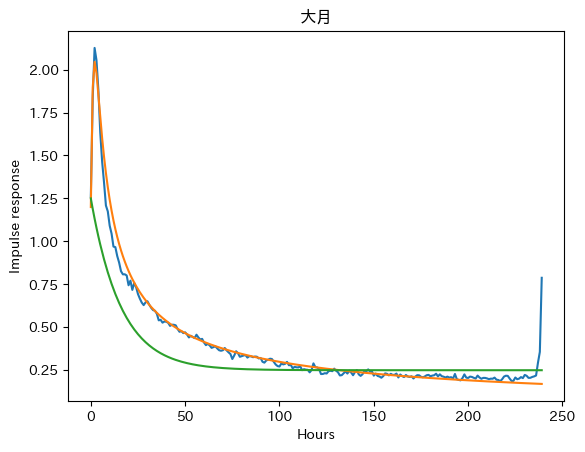

In [170]:
xtick = np.arange(0, len(coef) - 1)
plt.plot(xtick, coef[:-1])
# plt.plot(xtick, coef[:-1]-4/xtick**0.55-30/xtick**5)
# plt.plot(xtick, coef[:-1]-4/xtick**0.55-30/xtick**5+33/xtick**6)
plt.plot(xtick, 6 / (xtick + 1) ** 0.65 - 15000 / (xtick + 5) ** 5)
plt.plot(xtick, np.exp(-xtick / 16) + 0.25)
plt.xlabel("Hours")
plt.ylabel("Impulse response")
plt.title("大月")
# plt.xscale("log")
# plt.yscale("log")

大月では、降雨の影響が非常に長く持続するようだ。地下水の湧き出しなども関係しているかもしれない。200時間程度の遅延を見込んだほうがよい。



流量でインパルス応答を計算した場合。

/Users/matto/My Drive/DataAnalysis/相模湖・津久井湖土地・水質/yamanashi-water/level/level.py:73: RuntimeWarning: invalid value encountered in divide
  X_ = np.zeros([L, lookback]) / 0


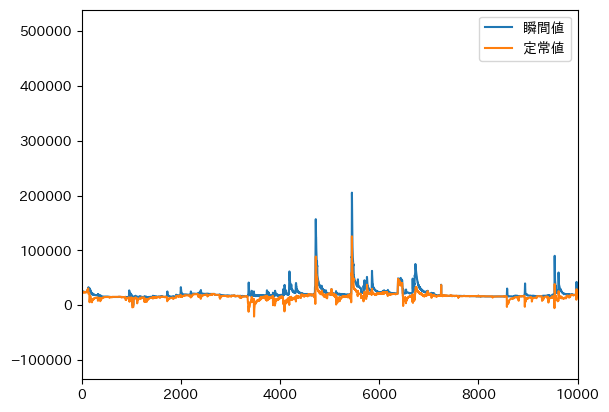

Text(0.5, 1.0, '大月')

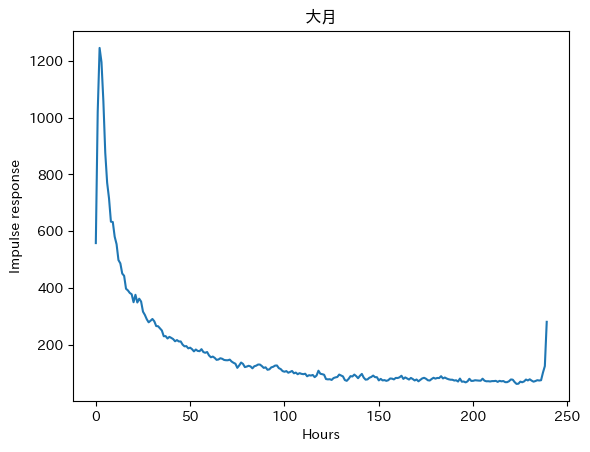

In [15]:
import matplotlib.pyplot as plt

ticks = merge_rain_and_level(大月雨量, 大月流量)
coef = regression(ticks.大月雨量, ticks.大月流量, lookback=24 * 10, ax=plt)
plt.xlim(0, 10000)
plt.legend()
plt.show()
plt.plot(coef[:-1])
plt.xlabel("Hours")
plt.ylabel("Impulse response")
plt.title("大月")
# plt.yscale("log")

インパルス応答は本来なら0に落ちるべき。ベースラインの動きが関係している可能性はある、試しに、yから100時間移動平均を引いて、短時間の動きだけにしてからインパルス応答を計算してみよう。

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/3758949761.py:8: RuntimeWarning: invalid value encountered in divide
  X_ = np.zeros([L, lookback]) / 0


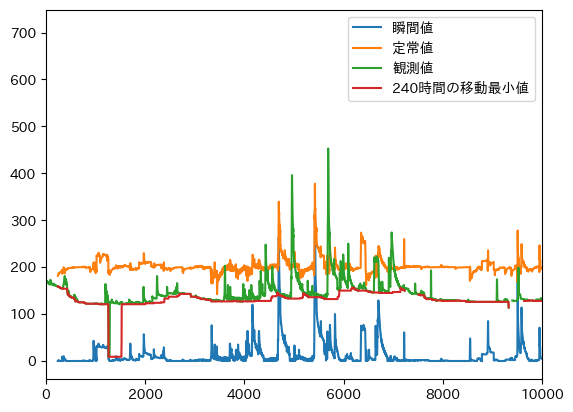

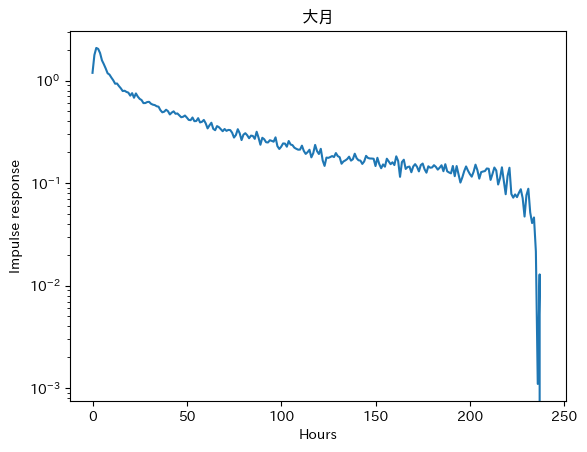

In [203]:
coef = regression(
    ticks.大月雨量, ticks.大月水位, lookback=24 * 10, ax=plt, rolling_window=240
)
plt.xlim(0, 10000)
plt.legend()
plt.show()
plt.plot(coef[:-1])
plt.xlabel("Hours")
plt.ylabel("Impulse response")
plt.title("大月")
plt.yscale("log")

意外にも、移動最小値を引くことはあまり効果がない。

まとめる。

In [113]:
大月水位 = scan_data("大月水位")
大月雨量 = scan_data("大月雨量")

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


04/01 00:00
07/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


03/01 00:00
01/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


02/01 00:00
08/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


11/01 00:00
09/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


06/01 00:00
05/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


05/01 00:00
06/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


12/01 00:00
08/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


11/01 00:00
10/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


09/01 00:00
07/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


04/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/35702

04/01 00:00
07/01 00:00
03/01 00:00
01/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


02/01 00:00
08/01 00:00
11/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


09/01 00:00
06/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


05/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


05/01 00:00
06/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


12/01 00:00
08/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


11/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


10/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)
/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


09/01 00:00
07/01 00:00


/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/357029872.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.datetime = pd.to_datetime(df.datetime)


04/01 00:00


「大月 雨量」と「大月雨量」が混在していて邪悪。

<Axes: xlabel='datetime'>

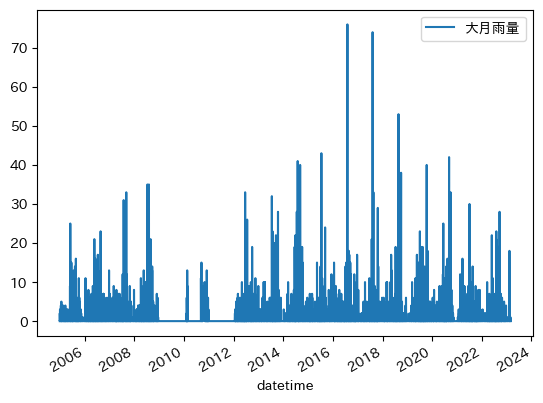

In [47]:
大月雨量.plot("datetime", "大月雨量")

[[nan nan]
 [nan nan]]


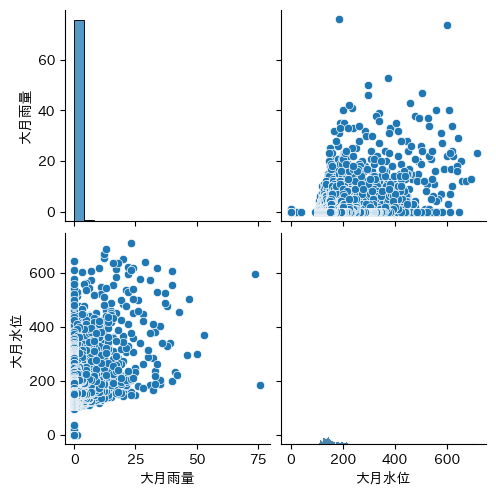

In [48]:
# 同じ時刻に2つの値がある場合はどちらも信用しない。
大月雨量 = 大月雨量.drop_duplicates(["datetime"], keep=False)
大月水位 = 大月水位.drop_duplicates(["datetime"], keep=False)

ticks = merge_rain_and_level(大月雨量, 大月水位)
sns.pairplot(ticks[["大月雨量", "大月水位"]])
print(np.corrcoef(ticks.大月水位, ticks.大月雨量))

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_35491/350479342.py:7: RuntimeWarning: invalid value encountered in divide
  X_ = np.zeros([L, lookback]) / 0


(159192, 73)


Text(0.5, 1.0, '大月')

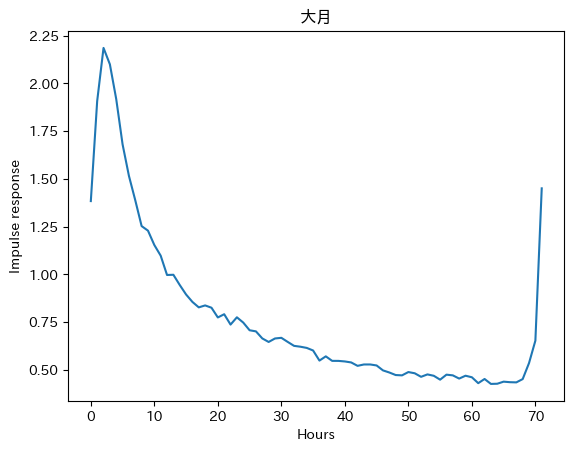

In [49]:
coef = regression(ticks.大月雨量, ticks.大月水位, lookback=24 * 3)
plt.plot(coef)
plt.xlabel("Hours")
plt.ylabel("Impulse response")
plt.title("大月")
# plt.yscale("log")

In [301]:
coef

array([1.38364891, 1.90724726, 2.18576857, 2.09995322, 1.91782832,
       1.68084711, 1.51560404, 1.38773977, 1.25267497, 1.2287953 ,
       1.15359435, 1.09783717, 0.99667817, 0.9977856 , 0.94431516,
       0.89445949, 0.85550192, 0.82709635, 0.83726937, 0.82522472,
       0.77427088, 0.79115295, 0.73693714, 0.77505536, 0.74748718,
       0.70719675, 0.70136065, 0.66440682, 0.64591865, 0.66418789,
       0.667613  , 0.64618349, 0.62551244, 0.62104215, 0.6147303 ,
       0.60121569, 0.5483759 , 0.57054009, 0.54692914, 0.5467574 ,
       0.5438485 , 0.53860828, 0.52083945, 0.52797202, 0.52803296,
       0.52285072, 0.4970442 , 0.48601801, 0.47270931, 0.47102596,
       0.48831606, 0.48196269, 0.4633615 , 0.47599382, 0.46883037,
       0.44843745, 0.47466805, 0.47098665, 0.45413235, 0.46913687,
       0.46102068, 0.43012577, 0.45201452, 0.42617257, 0.42717067,
       0.43804113, 0.43523138, 0.43427271, 0.45145672, 0.53545327,
       0.65278912, 1.45037017])

良い感じ。この調子で、すべての地点でインパルス応答を作画するとどうなるだろう。

In [7]:
# すべての地点を抽出する。例えば一番古いデータから。

import os
import pandas as pd


def scan_locations(year="2006"):
    cols = set()
    for root, dirs, files in os.walk("../神奈川県河港課水位・雨量データ"):
        for file in files:
            if file[-4:] == ".csv":
                filename = root + "/" + file
                # 正時データ以外は読むな
                if not ("seiji" in filename or "正時" in filename):
                    continue
                fileyear = assume_year(filename)
                if year != fileyear:
                    continue
                df = None
                for enc in ("shift-jis", "utf8", "cp932"):
                    try:
                        df = pd.read_csv(filename, encoding=enc, header=0)
                    except:
                        pass
                    if df is not None:
                        break
                if df is not None:
                    cols |= set(df.columns)
    return cols


locs = [loc for loc in scan_locations()]
levels = set([loc[:-2] for loc in locs if "水位" in loc])
rains = set([loc[:-2] for loc in locs if "雨量" in loc])
levels & rains

{'上土棚新橋',
 '六浦二号',
 '土堀田橋',
 '埋田橋',
 '堰橋',
 '大月',
 '大泉河原橋',
 '大町橋',
 '大竹上橋',
 '宮城野',
 '宮崎橋（旧横浜治水）',
 '寒川',
 '寺家橋',
 '小鮎',
 '岡上橋',
 '新三輪橋',
 '新産川橋',
 '昭和橋',
 '湖尻水門',
 '源氏橋',
 '田代橋',
 '石橋',
 '福田10号橋',
 '綱島',
 '若宮橋',
 '西ヶ崎橋',
 '高鎌橋',
 '鮎沢'}

地名が得られたので、これをループを回す。

In [25]:
coefs = dict()
data = dict()

In [ ]:
from collections import namedtuple

雨量水位 = namedtuple("雨量水位", ["雨量", "水位"])

for loc in list(levels & rains):
    print(loc)
    if loc in coefs:
        continue
    水位 = scan_data(f"{loc}水位")
    雨量 = scan_data(f"{loc}雨量")

    if 水位 is None or 雨量 is None:
        print("No data")
        continue

    雨量 = 雨量.drop_duplicates(["datetime"], keep=False)
    水位 = 水位.drop_duplicates(["datetime"], keep=False)

    # print(雨量.shape, 水位.shape)
    if 雨量.shape[0] > 0:
        ticks = merge_rain_and_level(雨量, 水位)
        ticks.columns = ["unixtime", "datetime", "雨量", "水位"]
        coef = regression(ticks.雨量, ticks.水位, lookback=24 * 3)
        print(coef[:10])
        coefs[loc] = coef
        data[loc] = 雨量水位(雨量, 水位)

(0.01, 10)

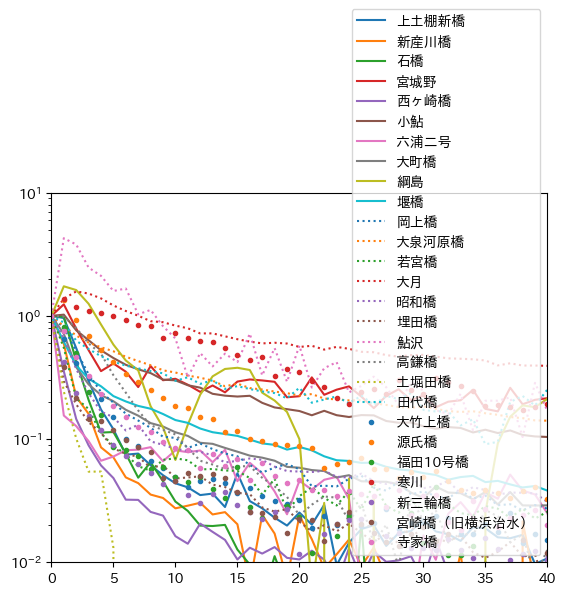

In [27]:
import matplotlib.pyplot as plt

for i, loc in enumerate(coefs):
    pattern = ["-", ":", "."][i // 10]
    plt.plot(coefs[loc] / coefs[loc][0], pattern, label=loc)

plt.legend()
plt.xlim(0, 40)
plt.yscale("log")
plt.ylim(0.01, 10)

# 尽きせぬ疑問

1. なぜ大月は減衰が遅いのか。定常流(長時間成分)をさしひいた場合にインパルス応答の減衰はどれぐらい変わるか。
    * これも上でやってみたが、定常流の寄与はインパルス応答にあまり関係しない。
2. 水位と、雨量から計算した予測値の差をとると、定常成分の時間変化が見られるはず。それは、ダムの放流などを反映しているとおもわれる。
    * 上でやってみたが、それほど明確には分離できない。
3. 各地点での降水量がどの程度同期しているのかを知りたい。例えば大月と昭和橋。

In [44]:
# 1. 欠測を無視し、大月の数列に

72

array([[1.        , 0.49198529],
       [0.49198529, 1.        ]])

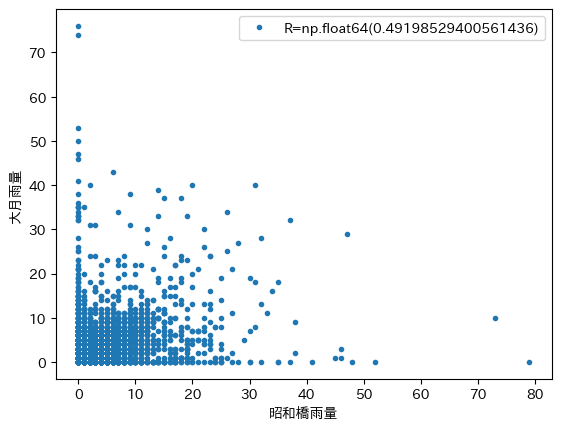

In [43]:
# 3. 各地点での降水量がどの程度同期しているのかを知りたい。例えば大月と昭和橋。
merged = pd.merge(data["昭和橋"].雨量, data["大月"].雨量, on="datetime", how="left")
merged.dropna(inplace=True)
R = np.corrcoef(merged.昭和橋雨量, merged.大月雨量)[0, 1]
plt.plot(merged.昭和橋雨量, merged.大月雨量, ".", label=f"{R=}")
plt.xlabel("昭和橋雨量")
plt.ylabel("大月雨量")
plt.legend()
np.corrcoef(merged.昭和橋雨量, merged.大月雨量)

# そこそこ相関しているが、県内全域で同じように雨が降ると考えるのは難しいかもしれない。

In [31]:
data["昭和橋"].雨量

,datetime,昭和橋雨量
0,2005-01-01 00:00:00+09:00,0.0
1,2005-01-01 01:00:00+09:00,0.0
2,2005-01-01 02:00:00+09:00,0.0
3,2005-01-01 03:00:00+09:00,0.0
4,2005-01-01 04:00:00+09:00,0.0
...,...,...
667,2023-02-28 19:00:00+09:00,0.0
668,2023-02-28 20:00:00+09:00,0.0
669,2023-02-28 21:00:00+09:00,0.0
670,2023-02-28 22:00:00+09:00,0.0


# 以下は、データの分析と前処理の検討。

In [5]:
dfs.plot("datetime", "昭和橋雨量")

KeyError: '昭和橋雨量'

<Axes: xlabel='datetime'>

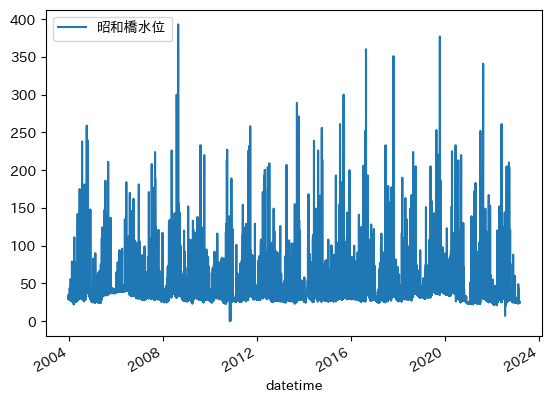

In [6]:
dfs.plot("datetime", "昭和橋水位")

同じ時刻のデータがある可能性がある。同じ値なら問題はない。確認する。

In [145]:
import numpy as np

# dfs = dfs.sort_values(by="datetime")
# 同じ時刻
sametime = dfs.datetime.duplicated()
# 行全体が同じ
samerow = dfs.duplicated()

print(np.sum(sametime), np.sum(samerow))

185515 177677


日付が重複しているだけでなく同じ日に異なる数値が記録されている場合がある。とりあえず単純な重複は除く。

In [147]:
dfs2 = dfs.drop_duplicates()

同じ時刻に違う値が記録されているケース。大差なければ気にしないが。

(np.float64(14641.0), np.float64(14644.0))

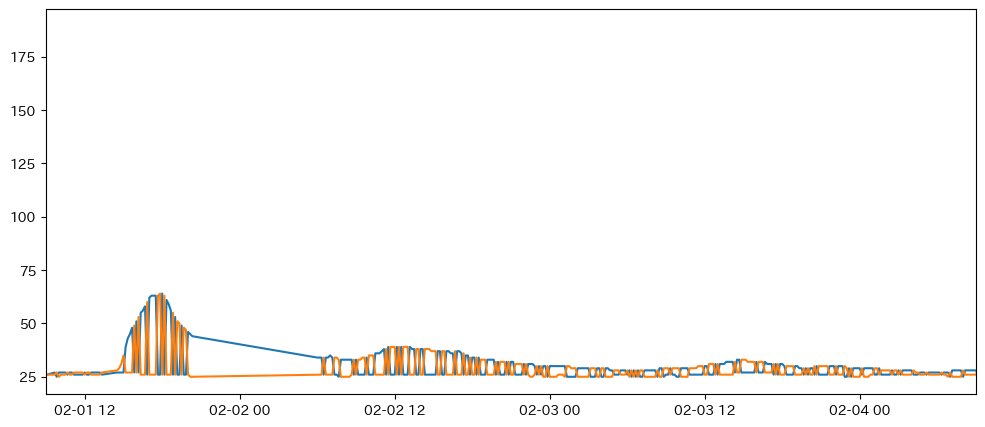

In [162]:
import datetime

fig = plt.figure(figsize=(12, 5))
sametime = dfs2[dfs2.datetime.duplicated(keep="first")]
plt.plot(sametime.datetime, sametime.昭和橋水位)
sametime = dfs2[dfs2.datetime.duplicated(keep="last")]
plt.plot(sametime.datetime, sametime.昭和橋水位)
plt.xlim(datetime.date(2010, 2, 1), datetime.date(2010, 2, 4))

2種類のデータが混ざっている。可能性としては、昭和橋でない場所での計測の値に昭和橋と書いてしまった可能性がある。

全く信用できないので、両者ともdropする。

In [163]:
dfs2 = dfs2[~dfs2.datetime.duplicated(keep=False)]
dfs2

,datetime,昭和橋水位
0,2004-01-01 00:00:00+09:00,33.0
6,2004-01-01 01:00:00+09:00,33.0
12,2004-01-01 02:00:00+09:00,32.0
18,2004-01-01 03:00:00+09:00,31.0
24,2004-01-01 04:00:00+09:00,32.0
...,...,...
4027,2023-02-28 23:10:00+09:00,24.0
4028,2023-02-28 23:20:00+09:00,24.0
4029,2023-02-28 23:30:00+09:00,24.0
4030,2023-02-28 23:40:00+09:00,24.0


10分単位のデータは今は使わないのでdropする。

In [164]:
dfs2 = dfs2[dfs2.datetime.dt.minute == 0]
dfs2

,datetime,昭和橋水位
0,2004-01-01 00:00:00+09:00,33.0
6,2004-01-01 01:00:00+09:00,33.0
12,2004-01-01 02:00:00+09:00,32.0
18,2004-01-01 03:00:00+09:00,31.0
24,2004-01-01 04:00:00+09:00,32.0
...,...,...
4002,2023-02-28 19:00:00+09:00,24.0
4008,2023-02-28 20:00:00+09:00,24.0
669,2023-02-28 21:00:00+09:00,24.0
670,2023-02-28 22:00:00+09:00,24.0


In [61]:
(2023 - 2004) * 365 * 24

166440

ちょっとデータ数が足りていないのは、欠測のせいか?

In [165]:
dfs2.sort_values(by="datetime", inplace=True)
dfs2 = dfs2.reset_index()
# dfs2 = dfs2.set_index("datetime")
dfs2

/var/folders/g2/t_qwkbf48xj4860059bm17mh0000gs/T/ipykernel_37297/3960739948.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs2.sort_values(by="datetime", inplace=True)


,index,datetime,昭和橋水位
0,0,2004-01-01 00:00:00+09:00,33.0
1,6,2004-01-01 01:00:00+09:00,33.0
2,12,2004-01-01 02:00:00+09:00,32.0
3,18,2004-01-01 03:00:00+09:00,31.0
4,24,2004-01-01 04:00:00+09:00,32.0
...,...,...,...
159408,4002,2023-02-28 19:00:00+09:00,24.0
159409,4008,2023-02-28 20:00:00+09:00,24.0
159410,669,2023-02-28 21:00:00+09:00,24.0
159411,670,2023-02-28 22:00:00+09:00,24.0


In [166]:
unixtime = dfs2.datetime.map(lambda x: x.timestamp()).to_numpy() / 3600
unixtime

array([298023., 298024., 298025., ..., 465996., 465997., 465998.])

In [167]:
np.unique(unixtime[1:] - unixtime[:-1], return_counts=True)

(array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
         12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
         23.,  24.,  25.,  26.,  28.,  29.,  30.,  31.,  32.,  33.,  35.,
         37.,  38.,  39.,  40.,  41.,  42.,  47.,  48.,  53.,  55.,  56.,
         62.,  63.,  64.,  65.,  70.,  71.,  74.,  85.,  89.,  91., 104.,
        106., 117., 132., 155., 173., 263., 673., 745.]),
 array([158491,    367,    101,     74,     51,     36,     33,     34,
            18,     13,     23,     25,     13,     10,     12,      9,
             3,      8,      7,      3,      6,      6,      4,      3,
             8,      2,      2,      3,      2,      2,      1,      2,
             1,      1,      1,      1,      1,      2,      1,      1,
             2,      1,      1,      1,      1,      4,      3,      2,
             2,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1]))

最大745時間の欠測が生じているが、まあしかたがない。信頼できないデータは統計に使えない。

等間隔時刻目盛りをつくり、そこにデータを流しこむ。欠測はNaNのままで放置。あとで削る。

array([[52745],
       [52747],
       [52749],
       ...,
       [61972],
       [61974],
       [61976]])

In [139]:
dfs2.iloc[52745:52755]

,index,datetime,昭和橋水位
52745,0,2010-02-01 00:00:00+09:00,26.0
52746,4464,2010-02-01 00:00:00+09:00,27.0
52747,1,2010-02-01 01:00:00+09:00,26.0
52748,6,2010-02-01 01:00:00+09:00,28.0
52749,2,2010-02-01 02:00:00+09:00,26.0
52750,12,2010-02-01 02:00:00+09:00,27.0
52751,18,2010-02-01 03:00:00+09:00,27.0
52752,3,2010-02-01 03:00:00+09:00,26.0
52753,24,2010-02-01 04:00:00+09:00,26.0
52754,30,2010-02-01 05:00:00+09:00,26.0


In [142]:
np.sum(dfs2.datetime.duplicated())

np.int64(1308)